In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import numpy as np


In [65]:
fs = 10
plt.rcParams.update({
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

In [60]:
data = pd.read_csv('/Users/treents/project/aiida-cwf/data/wien2k/SCAN_tests/summary_pbe_scan_r2scan_r2scan01-2missing.txt', sep='\s+', header=1)
data.columns = ['element', 'pbe', 'scan', 'r2scan', 'r2scan01']
data = data.set_index('element')

In [61]:
data

,pbe,scan,r2scan,r2scan01
element,,,,
Ag,4.1478,4.0823,4.1045,4.1068
Al,4.0407,4.0119,3.9953,3.9958
AlAs,5.7284,5.6718,5.6791,5.6804
AlN,4.4025,4.3620,4.3708,4.3712
AlP,5.5071,5.4726,5.4787,5.4794
Au,4.1585,4.0950,4.1253,4.1273
Ba,5.0219,5.0783,5.0694,5.0709
BN,3.6247,3.6044,3.6098,3.6099
BP,4.5483,4.5283,4.5363,4.5367


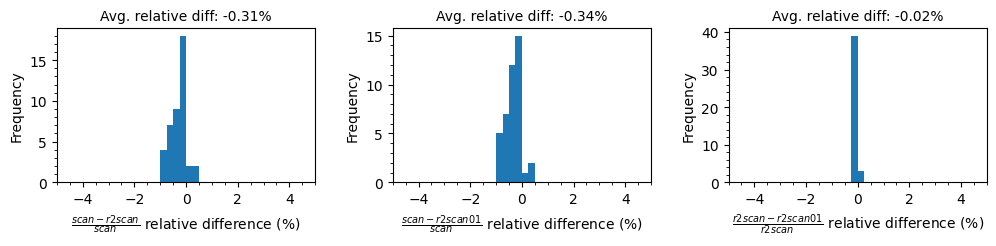

In [76]:
diff_labels = list(combinations(data.drop('pbe', axis=1).columns, 2))

# Create subplots for relative differences
fig, axes = plt.subplots(nrows=len(diff_labels)//3, ncols=3, figsize=(12, 2.5*len(diff_labels)//3))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

# Plot each column in a separate subplot
for ax, labs in zip(axes.flatten(), diff_labels):
    relative_diff = (data[labs[0]] - data[labs[1]]) / data[labs[0]] * 100
    ax.hist(relative_diff, bins=np.arange(-10, 10, 0.25))
    # ax.set_title(f'Relative Difference of {col}')
    ax.set_xlabel(f'$\\frac{{{labs[0]} - {labs[1]}}}{{{labs[0]}}}$ relative difference (%)')
    ax.yaxis.get_major_locator().set_params(integer=True, nbins=5)
    ax.minorticks_on()
    ax.set_ylabel('Frequency')
    ax.set_xlim(-5, 5)
    ax.set_title(f'Avg. relative diff: {relative_diff.mean():.2f}%')

# plt.tight_layout()
plt.savefig('meta_gga_a0_diff.png', bbox_inches='tight')